In [1]:
!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import *
from IPython.display import display


In [2]:
start = datetime(2020,10,31)
end = datetime(2021,10,31)

In [3]:
Nvidia_Price = yf.download('NVDA', start, end)

[*********************100%***********************]  1 of 1 completed


In [4]:
display(Nvidia_Price)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-02,126.577499,128.367493,123.949997,125.807503,125.660599,29965200
2020-11-03,127.084999,131.050003,126.027496,130.195007,130.042969,27290000
2020-11-04,133.892502,138.274994,133.369995,137.942505,137.781418,41022800
2020-11-05,141.625000,143.389999,139.910004,141.600006,141.434662,31902800
2020-11-06,141.097504,145.887497,138.949997,145.619995,145.449951,38334800
...,...,...,...,...,...,...
2021-10-25,229.729996,233.550003,227.699997,231.660004,231.631638,23023500
2021-10-26,239.889999,252.589996,239.240005,247.169998,247.139740,48589800
2021-10-27,244.740005,250.899994,242.820007,244.509995,244.480057,24599000


In [5]:
close = Nvidia_Price.drop(labels = ['Open','High','Low','Adj Close','Volume'], axis = 1)

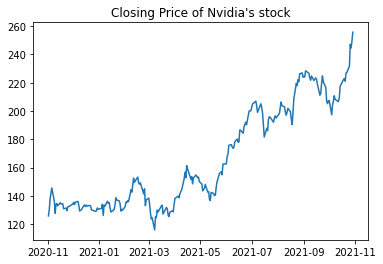

In [6]:
plt.figure()
plt.plot(close)
plt.title("Closing Price of Nvidia's stock")
plt.show()

In [31]:
Volatility = close.values.std()*np.sqrt(252)
print("The volatility of the stock is :", round(Volatility/100,2))

The volatility of the stock is : 5.7


In [8]:
import numpy.random as npr
def Asian_call_MC_BS(r,S,sigma,T,K,N,n):
    delta = float(T/n)
    G = npr.normal(0,1,size=(N,n))
    LR = (r-0.5*sigma**2)*delta+np.sqrt(delta)*sigma*G
    LR = np.concatenate((np.log(S)*np.ones((N,1)),LR),axis=1)
    LR = np.cumsum(LR,axis=1)
    Spaths = np.exp(LR)
    Spaths = Spaths[:,0:len(Spaths[0,:])-1]
    Sbar = np.mean(Spaths,axis=1)
    payoff = np.exp(-r*T)*np.maximum(Sbar-K,0) #call function
    Asian_MC_price = np.mean(payoff)
    sigma = np.std(payoff) # standard deviation estimator
    error = 1.96*sigma/np.sqrt(N)
    CI_up = Asian_MC_price + error
    CI_down = Asian_MC_price -error
    return Asian_MC_price,CI_up,CI_down,error


[Asian_MC_price,CI_up,CI_down,error]=Asian_call_MC_BS(0.05,100,0.2,1,100,3000000,100)    
print('*******MC_Price*****')
print(Asian_MC_price,CI_up,CI_down,error)

*******MC_Price*****
5.7116137166733285 5.720559273575394 5.702668159771263 0.008945556902065133


In [9]:
from tqdm import tqdm

In [10]:
#plot the price of the asian option with respect to the price of the underlying
asian_call_price = [Asian_call_MC_BS(0.05,stock,0.2,1,180,1000,100)[0] for stock in tqdm(close.values)]

100%|██████████| 251/251 [00:02<00:00, 111.88it/s]


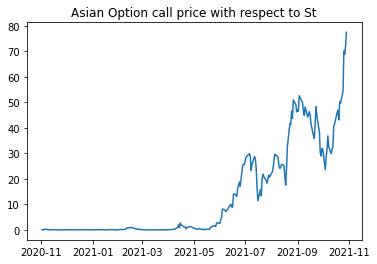

In [32]:
plt.figure()
plt.plot(close.index,asian_call_price)
plt.title('Asian Option call price with respect to St')
plt.show()

In [12]:
def Vanilla_Call_BSM(r,S,sigma,T,K):
    d1 = np.log(S/K) + (r + sigma**2)*T/(sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
  
def delta(r,S,sigma,T,K):
    d1 = np.log(S/K) + (r + sigma**2)*T/(sigma * np.sqrt(T))
    return norm.cdf(d1)
  
def vega(r,S,sigma,T,K):
    d1 = np.log(S/K) + (r + sigma**2)*T/(sigma * np.sqrt(T))
    return S*norm.pdf(d1)*np.sqrt(T)

def theta(r,S,sigma,T,K):
    d1 = np.log(S/K) + (r + sigma**2)*T/(sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -(S*norm.pdf(d1)*sigma)/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2)
  
def gamma(r,S,sigma,T,K):
    d1 = np.log(S/K) + (r + sigma**2)*T/(sigma * np.sqrt(T))
    return  norm.pdf(d1)/(S*sigma*np.sqrt(T))
  
def rho(r,S,sigma,T,K):
    d1 = np.log(S/K) + (r + sigma**2)*T/(sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*T*np.exp(-r*T)*norm.cdf(d2)

In [38]:
def Vanilla_call_MC_BS(r,S0,sigma,T,K,M,N):
    G = npr.randn(M,N+1) 
    S = (r - (sigma**2)/2) * (T/N) + sigma * np.sqrt(T/N) * G 
    S[:,0] = np.log(S0) 
    Sc = np.cumsum(S,1)
    Sce = np.exp(Sc)
    #minv = np.min(Sce,1) 
    #boolv = (minv >= 0)

    payoff = np.exp(-r * T) * np.maximum(Sce[:,N]-K,0) #* boolv

    return np.mean(payoff)

In [35]:
vanilla_call_price = [Vanilla_Call_BSM(0.05,stock,0.2,1,180) for stock in tqdm(close.values)]

100%|██████████| 251/251 [00:00<00:00, 4839.28it/s]


In [39]:
vanilla_call_price_MC = [Vanilla_call_MC_BS(0.05,stock,0.2,1,180,10000,100) for stock in close.values]

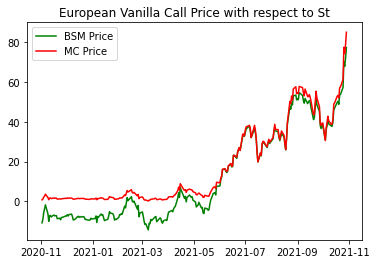

In [40]:
plt.figure()
plt.plot(close.index,vanilla_call_price, color = 'g', label = 'BSM Price')
plt.plot(close.index,vanilla_call_price_MC, color = 'r', label = 'MC Price')
plt.title('European Vanilla Call Price with respect to St')
plt.legend()
plt.show()

In [17]:
delta_vanilla_call = [delta(0.05,stock,0.2,1,180) for stock in tqdm(close.values)]

100%|██████████| 251/251 [00:00<00:00, 8103.28it/s]


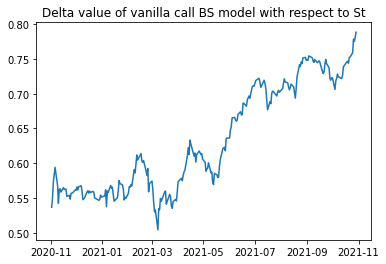

In [18]:
plt.figure()
plt.plot(close.index,delta_vanilla_call)
plt.title('Delta value of vanilla call BS model with respect to St')
plt.show()

In [19]:
vega_vanilla_call = [vega(0.05,stock,0.2,1,180) for stock in tqdm(close.values)]

100%|██████████| 251/251 [00:00<00:00, 6114.71it/s]


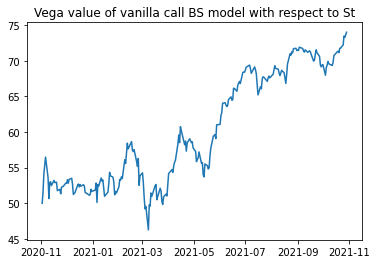

In [20]:
plt.figure()
plt.plot(close.index,vega_vanilla_call)
plt.title('Vega value of vanilla call BS model with respect to St')
plt.show()

In [21]:
theta_vanilla_call = [theta(0.05,stock,0.2,1,180) for stock in tqdm(close.values)]

100%|██████████| 251/251 [00:00<00:00, 4231.48it/s]


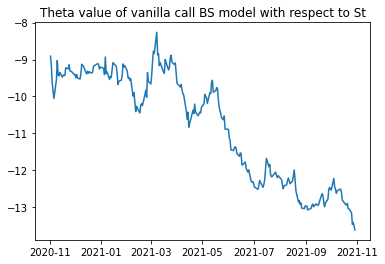

In [22]:
plt.figure()
plt.plot(close.index,theta_vanilla_call)
plt.title('Theta value of vanilla call BS model with respect to St')
plt.show()

In [23]:
rho_vanilla_call = [rho(0.05,stock,0.2,1,180) for stock in tqdm(close.values)]

100%|██████████| 251/251 [00:00<00:00, 7133.99it/s]


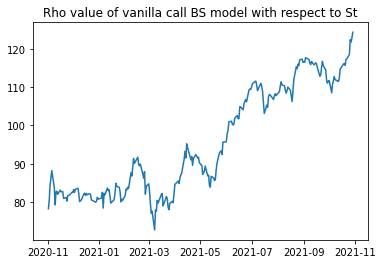

In [24]:
plt.figure()
plt.plot(close.index,rho_vanilla_call)
plt.title('Rho value of vanilla call BS model with respect to St')
plt.show()

In [25]:
gamma_vanilla_call = [gamma(0.05,stock,0.2,1,180) for stock in tqdm(close.values)]

100%|██████████| 251/251 [00:00<00:00, 7428.79it/s]


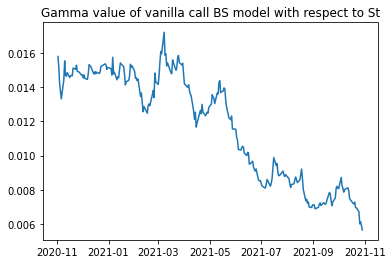

In [26]:
plt.figure()
plt.plot(close.index,gamma_vanilla_call)
plt.title('Gamma value of vanilla call BS model with respect to St')
plt.show()